# Projeto de Controle de Temperatura e Nível de Tanque

**Universidade Federal de Itajubá - Instituto de Engenharia Mecânica**

**EME905 - Controle de Sistemas Mecânicos**

**Autores**

- Ian Dias Viotti - ianviotti@unifei.edu.br

- Lucas Macedo Alencar - 32063626871@unifei.edu.br

**Data**: *18/11/2022*

# Sistema de Mistura
    
No processo, a água da saída da bomba 1 passa por uma unidade de aquecimento antes de chegar no tanque 1. O tanque 2 recebe a água aquecida do tanque 1 por meio de uma ligação interativa, e água do reservatório à temperatura ambiente por meio da bomba 2. O fluxo do tanque 1 para o tanque 2 é devido somente à diferença de nível entre os tanques, e pode ser controlado ajustando-se o nível do tanque 1. A válvula 1 permanece fechada e a válvula 2 é mantida em posição constante. O fluxo de saída do tanque 2 é descartado para a rede de esgoto.
    
As variáveis manipuladas do sistema são as velocidades de rotação das bombas, consequentemente seus fluxos, e a potência da unidade de aquecimento. A perda térmica para oambiente foi desprezada. As variáveis medidas são os níveis, as temperaturas da água em cada um dos tanques, e a temperatura de saída da unidade de aquecimento. Como variáveis controladas temos o nível e a temperatura da água no tanque 2.
    
> [1] SOUZA, P. E. F. DE, (2015). **Projeto e Controle de Processo de Mistura**. Trabalho de
Graduação em Engenharia de Controle e Automação, Publicação FT.TG-nº 019/2015, Faculdade de
Tecnologia, Universidade de Brasília, Brasília, DF, 57p

# Modelagem Matemática

Assumindo que as funções transferência (FT) dos processos são de primeira ordem e dadas por

$G(s)=\frac{K}{\tau s + 1}$

Basta identificar os parâmetros $K$ e $\tau$ de cada processo.

Pela modelagem de **controle simples** descrita em [1], o nível do tanque 2 é controlado pelo fluxo da bomba 2 ($F_2$) e a temperatura do tanque 2 é controlado pela potência do aquecedor ($Pot$). Tendo isso em vista, as FTs são dadas por

$\frac{H_2}{F_2} = G_{H_2}(s) = G_{10}(s) = \frac{K_{10}}{\tau_{10}s + 1}$

$\frac{T_2}{Pot} = G_{T_2}(s) = G_{1}(s)G_{3}(s)G_{7}(s) = \frac{K_{1}}{\tau_{1}s + 1}\frac{K_{3}}{\tau_{3}s + 1}\frac{K_{7}}{\tau_{7}s + 1}$

Considerando, agora a **modelagem cruzada**, a temperatura do tanque 2 é controlado pelo fluxo da bomba 2 ($F_2$) e o nível do tanque 2 é controlado pelo fluxo da bomba 1 ($F_1$). Dessa maneira, as FTs são dadas por:

$\frac{H_2}{F_1} = G_4(s)G_{11}(s)=\frac{K_{4}}{\tau_{4}s + 1}\frac{K_{11}}{\tau_{11}s + 1}$

$\frac{T_2}{F_2} = \frac{G_9(s)}{(\tau_{10}s+1)((\tau_5+\tau_{10})s+1)}$

O autor usou o método de linearização das equações diferenciais que regem o sistema para obter as constantes de cada FT. Os valores obtidos para as FTs de interesse são:

|FT|$K$|$\tau$| Var. de Entrada | Var. de Saída |
| - | - | - | - | - |
| 1 | $6.1E-4 [°C/W]$ | $0.1$ | $Pot [W]$ | $T_r [C°]$ |
| 3 | $1 [-]$ | $125$ | $T_r [°C]$ | $T_1 [°C]$ |
| 4 | $500 [s/m^2]$ | $62.5$ | $F_1 [m^3/s]$ | $H_1 [m]$ |
| 5 | $1 [-]$ | $62.5$ | $H_2 [m]$ | $H_1 [m]$ |
| 7 | $0.58 [-]$ | $54.2$ | $T_1 [°C]$ | $T_2 [°C]$ |
| 9 | $-3E-3 [°Cs/m^3]$ | $54.2$ | $F_2 [m^3/s]$ | $T_2 [°C]$ |
| 10 | $318 [s/m^2]$ | $40$ | $F_2 [m^3/s]$ | $ H_2 [m]$ |
| 11 | $0.63 [s/m^2]$ | $40$ | $H_1 [m]$ | $ H_2 [m]$ |

# Análise Numérica

## Bibliotecas
Para a modelagem de controle, utilizou-se a biblioteca [Control - Python](https://github.com/python-control/python-control), para os cálculos numéricos utilizou-se a biblioteca [Numpy](https://numpy.org/) e para o plot dos gráficos, utilizou-se a biblioteca [Matplotlib](https://matplotlib.org/).

In [1]:
import control as ct
import control.matlab as ml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 200
%matplotlib widget

## Modelagem dos Sistemas

In [2]:
# Funções Transferência do sistema
G1 = ct.tf([6.1E-4], [0.1, 1])
G3 = ct.tf([1], [125, 1])
G4 = ct.tf([500], [62.5, 1])
G5 = ct.tf([1], [62, 1])
G7 = ct.tf([0.58], [54.2, 1])
G9 = ct.tf([-3E3],[54.2, 1])
G10 = ct.tf([318], [40, 1])
G11 = ct.tf([0.63], [40, 1])

# Temperatura do tanque 2
G_T2 = ct.series(G1, G3, G7)

# Nível do tanque 2
G_H2 = G4*G11/(1-G5*G11)

In [3]:
sis_H2 = G_H2/(1+G_H2)
sis_H2 = ct.feedback(G_H2, 1)
sis_T2 = G_T2/(1+G_T2)

In [4]:
n = 1000
t = np.linspace(0, 300, n)
step_H2 = np.ones(n)*0.06 # 6 cm
step_T2 = np.ones(n)*0.5 # 0,5 graus

H2_step = ct.forced_response(sis_H2, T=t, U=step_H2)
T2_step = ct.forced_response(sis_T2, T=t, U=step_T2)

## Compensador do nível do tanque

### Requisitos do sistema compensado

In [5]:
pos = 30 # percentage overshoot
Tp = 60 # peak time
Kp = 15 # velocity error constant

### Modelagem do sistema compensado

In [6]:
G_sis = G_H2
s = ct.tf([1,0],[1])
K = Kp/ct.dcgain(G_sis)
G = K*G_sis

zr = (-np.log(pos/100))/(np.sqrt(np.pi**2+np.log(pos/100)**2))
Pmr = np.arctan(2*zr/np.sqrt(-2*zr**2+np.sqrt(1+4*zr**4)))*(180/np.pi)
wnr = np.pi/(Tp*np.sqrt(1-zr**2))
wBW = wnr*np.sqrt((1-2*zr**2)+np.sqrt(4*zr**4-4*zr**2+2))
M, P, w = ct.bode(G, plot=False)
Gm, Pm, Wcg, Wcp = ct.margin(G)
Pmreq = np.arctan(2*zr/(np.sqrt(-2*zr**2+np.sqrt(1+4*zr**4))))*(180/np.pi)
Pmreqc = Pmreq + 10
Pc = Pmreqc - Pm

In [7]:
beta = (1-np.sin(Pc*np.pi/180))/(1+np.sin(Pc*np.pi/180))
magpc = 1/np.sqrt(beta)
for i in range(len(M)):
    if M[i] - (1/magpc) <=0:
        wmax = w[i]
        break

In [8]:
zc = wmax*np.sqrt(beta)
pc = zc/beta
Kc = 1/beta
Gc = Kc*ct.tf([1, zc], [1, pc])
Ge = G*Gc
sGe = s*Ge
sGe = ct.minreal(sGe)
Kp = ct.dcgain(Ge)
H2_ct = ct.feedback(Ge, 1)
Gc

1 states have been removed from the model


TransferFunction(array([1.03370559, 0.0416688 ]), array([1.       , 0.0416688]))

### Resposta no tempo

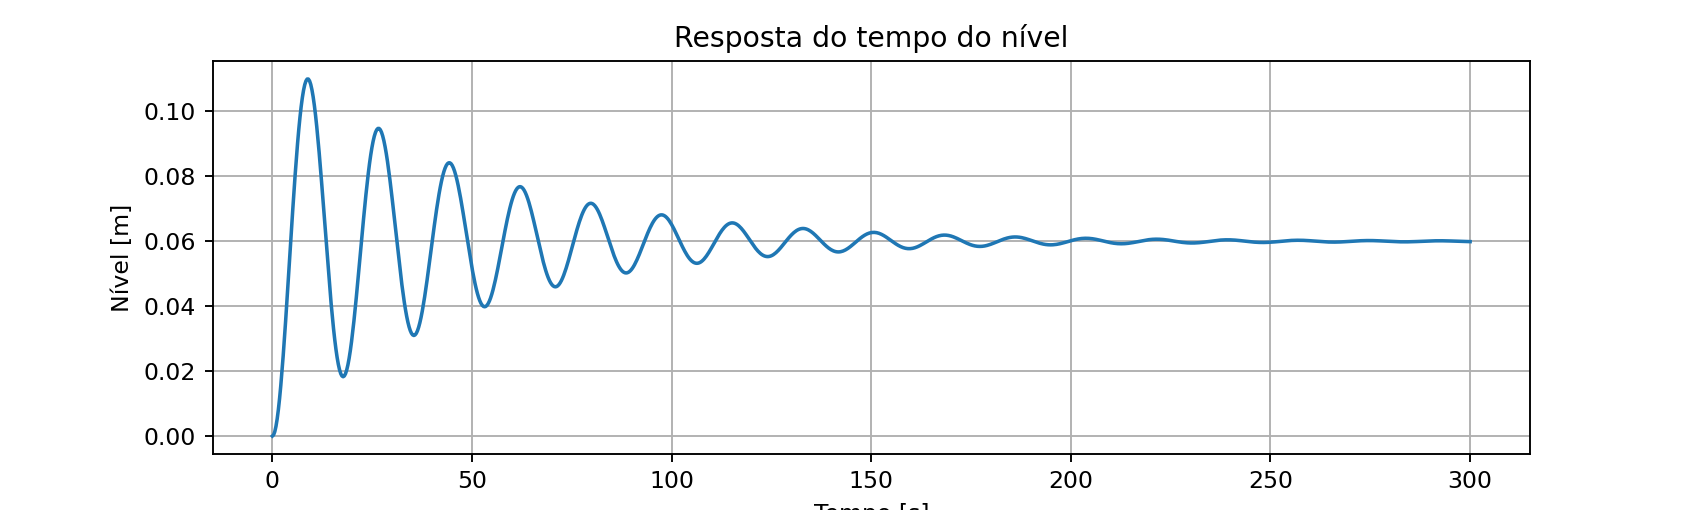

In [24]:
H2_ct_step = ct.forced_response(H2_ct, T=t, U=step_H2)

fig1, ax1 = plt.subplots(1, 1, figsize=(10,3), dpi = 170)
ax1.plot(H2_step.time, H2_step.outputs, label='não compensado')
ax1.plot(H2_ct_step.time, H2_ct_step.outputs, label='compensado')
ax1.grid()
ax1.set(title='Resposta do tempo do nível', xlabel='Tempo [s]', ylabel='Nível [m]')
ax1.legend()
plt.show()

### Diagrama de Bode

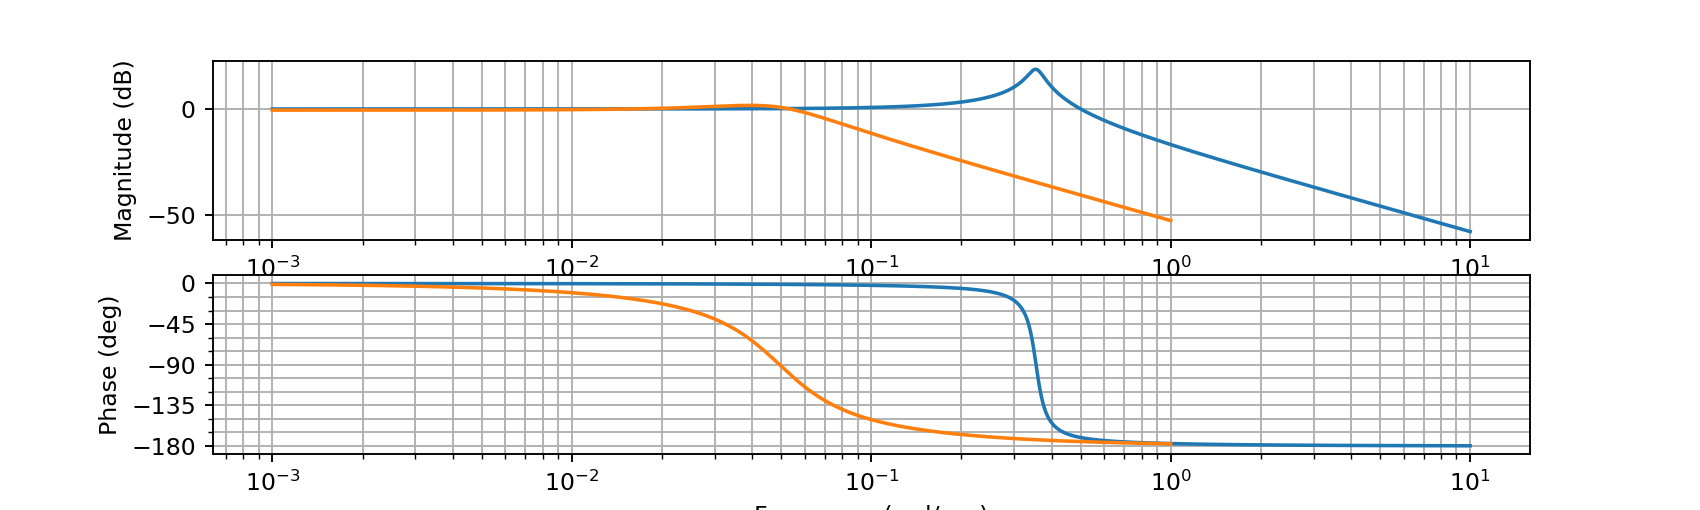

In [10]:
ct.bode(sis_H2)
ct.bode(H2_ct)
plt.show()

### Parâmetros do sistema compensado

In [11]:
print('===Requisitos do Compensador===')
print('Overshoot: ', pos)
print('Tempo de pico: ', Tp)
print('Constante de posição: ', Kp)
print('\n===Funções Transferências===')
print('Sistema não compensado: ', G_sis)
print('Sistema com ganho: ', G)
print('Compensador: ', Gc)
print('Sistema com feedback e compensado: ', H2_ct)
print('\n===Parâmetros Dinâmicos do Sistema===')
print('Fator de amortecimento requerido: ', zr)
print('Magem de fase requerida: ', Pmr)
print('Frequência natural requerida: ', wnr)
print('Largura de banda requerida: ', wBW)
print('Margem de fase atual (corrigida com 10°): ', Pmreqc)
print('Contribuição de fase: ', Pc)
print('\n===Dimensionamento do Compensador===')
print('Beta: ', beta)
print('Magnitude de pico: ', magpc)
print('Frequência na magnitude de pico: ', wmax)
print('Frequência de corte baixa: ', zc)
print('Frequência de corte alta: ', pc)
print('Ganho do compensador: ', Kc)

===Requisitos do Compensador===
Overshoot:  30
Tempo de pico:  60
Constante de posição:  14.999999999999996

===Funções Transferências===
Sistema não compensado:  
             7.812e+05 s^2 + 3.213e+04 s + 315
------------------------------------------------------------
6.2e+06 s^4 + 5.092e+05 s^3 + 1.386e+04 s^2 + 139.9 s + 0.37

Sistema com ganho:  
               1.376e+04 s^2 + 566.1 s + 5.55
------------------------------------------------------------
6.2e+06 s^4 + 5.092e+05 s^3 + 1.386e+04 s^2 + 139.9 s + 0.37

Compensador:  
1.034 s + 0.04167
-----------------
   s + 0.04167

Sistema com feedback e compensado:  
               1.423e+04 s^3 + 1159 s^2 + 29.33 s + 0.2313
-------------------------------------------------------------------------
6.2e+06 s^5 + 7.675e+05 s^4 + 4.931e+04 s^3 + 1876 s^2 + 35.53 s + 0.2467


===Parâmetros Dinâmicos do Sistema===
Fator de amortecimento requerido:  0.3578571305033167
Magem de fase requerida:  39.09011496449513
Frequência natural requerid

## Compensador da temperatura do tanque

### Requisitos do sistema compensado

In [12]:
pos = 30 # percentage overshoot
Tp = 60 # peak time
Kp = 15 # velocity error constant

### Modelagem do sistema compensado

In [14]:
G_sis = G_T2
s = ct.tf([1,0],[1])
K = Kp/ct.dcgain(G_sis)
G = K*G_sis

zr = (-np.log(pos/100))/(np.sqrt(np.pi**2+np.log(pos/100)**2))
Pmr = np.arctan(2*zr/np.sqrt(-2*zr**2+np.sqrt(1+4*zr**4)))*(180/np.pi)
wnr = np.pi/(Tp*np.sqrt(1-zr**2))
wBW = wnr*np.sqrt((1-2*zr**2)+np.sqrt(4*zr**4-4*zr**2+2))
M, P, w = ct.bode(G, plot=False)
Gm, Pm, Wcg, Wcp = ct.margin(G)
Pmreq = np.arctan(2*zr/(np.sqrt(-2*zr**2+np.sqrt(1+4*zr**4))))*(180/np.pi)
Pmreqc = Pmreq + 10
Pc = Pmreqc - Pm

In [15]:
beta = (1-np.sin(Pc*np.pi/180))/(1+np.sin(Pc*np.pi/180))
magpc = 1/np.sqrt(beta)
for i in range(len(M)):
    if M[i] - (1/magpc) <=0:
        wmax = w[i]
        break

In [16]:
zc = wmax*np.sqrt(beta)
pc = zc/beta
Kc = 1/beta
Gc = Kc*ct.tf([1, zc], [1, pc])
Ge = G*Gc
sGe = s*Ge
sGe = ct.minreal(sGe)
Kp = ct.dcgain(Ge)
T2_ct = ct.feedback(Ge, 1)
Gc

0 states have been removed from the model


TransferFunction(array([1.82014745, 0.07190846]), array([1.        , 0.07190846]))

### Resposta no tempo

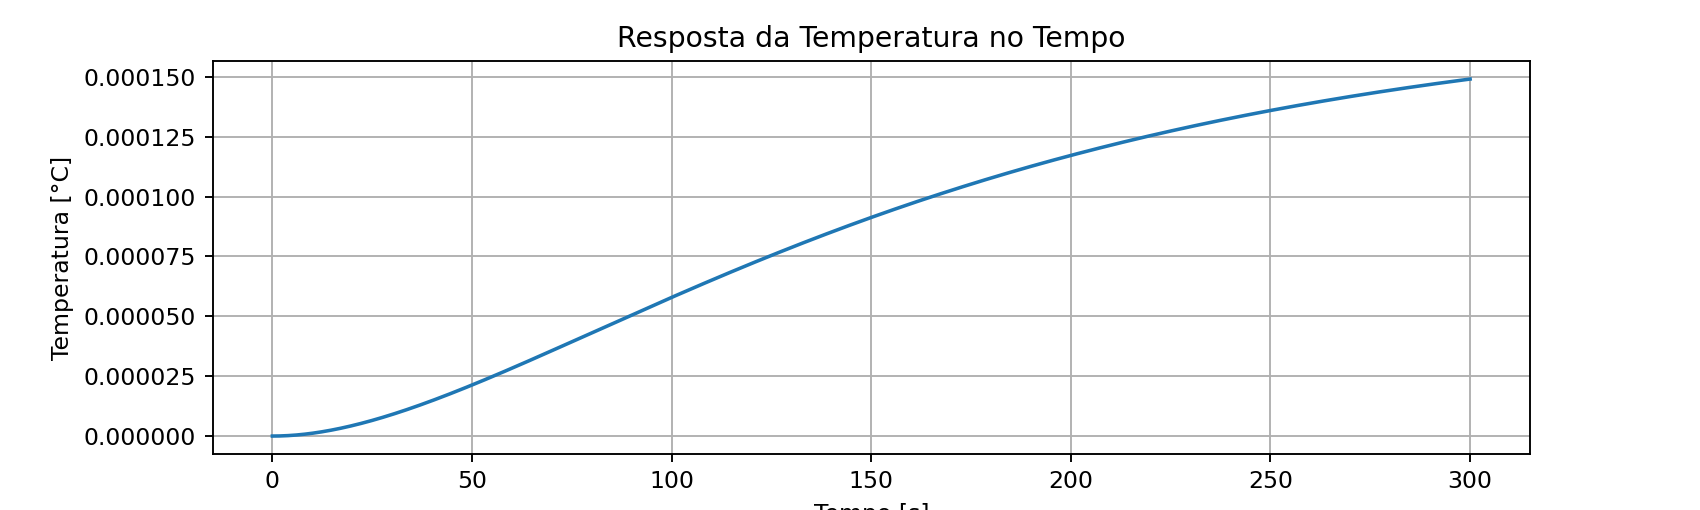

In [22]:
T2_ct_step = ct.forced_response(T2_ct, T=t, U=step_T2)

fig2, ax2 = plt.subplots(1, 1, figsize=(10,3), dpi = 170)
ax2.plot(T2_step.time, T2_step.outputs, label='não compensado')
ax2.plot(T2_ct_step.time, T2_ct_step.outputs, label='compensado')
ax2.grid()
ax2.set(title='Resposta da Temperatura no Tempo', xlabel='Tempo [s]', ylabel='Temperatura [°C]')
ax2.legend()
plt.show()

### Diagrama de Bode

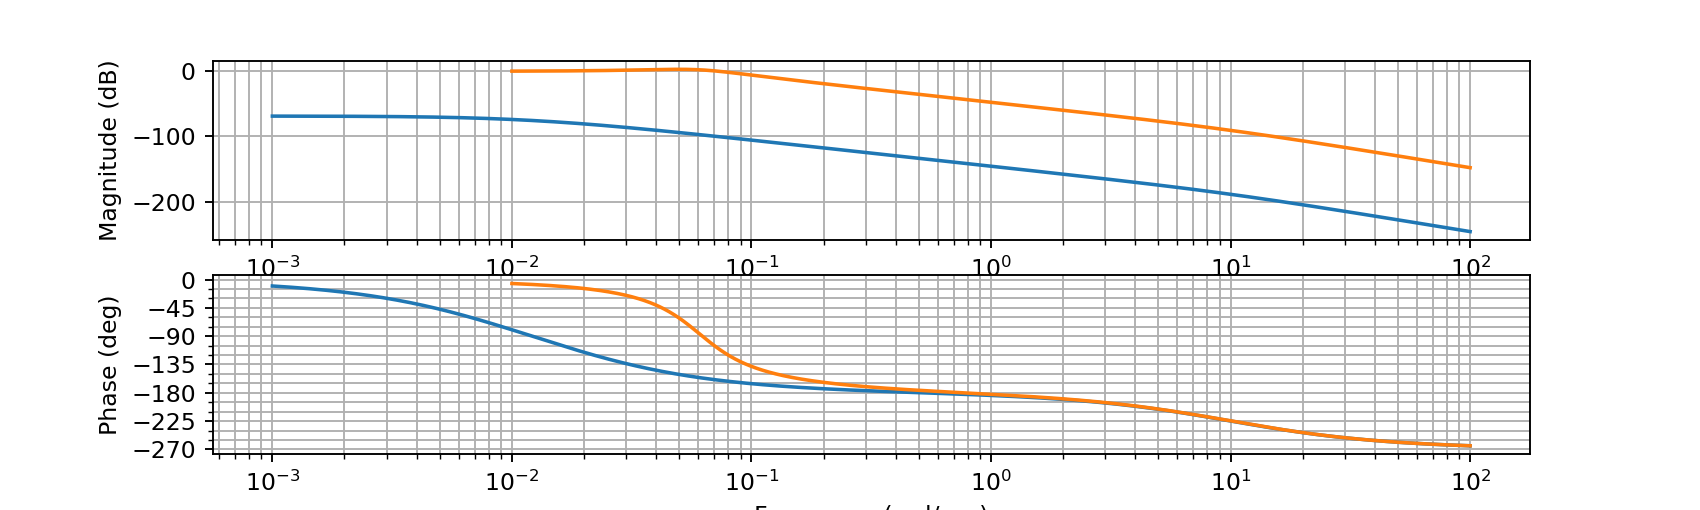

In [18]:
ct.bode(sis_T2)
ct.bode(T2_ct)
plt.show()

### Parâmetros do sistema compensado

In [19]:
print('===Requisitos do Compensador===')
print('Overshoot: ', pos)
print('Tempo de pico: ', Tp)
print('Constante de posição: ', Kp)
print('\n===Funções Transferências===')
print('Sistema não compensado: ', G_sis)
print('Sistema com ganho: ', G)
print('Compensador: ', Gc)
print('Sistema com feedback e compensado: ', H2_ct)
print('\n===Parâmetros Dinâmicos do Sistema===')
print('Fator de amortecimento requerido: ', zr)
print('Magem de fase requerida: ', Pmr)
print('Frequência natural requerida: ', wnr)
print('Largura de banda requerida: ', wBW)
print('Margem de fase atual (corrigida com 10°): ', Pmreqc)
print('Contribuição de fase: ', Pc)
print('\n===Dimensionamento do Compensador===')
print('Beta: ', beta)
print('Magnitude de pico: ', magpc)
print('Frequência na magnitude de pico: ', wmax)
print('Frequência de corte baixa: ', zc)
print('Frequência de corte alta: ', pc)
print('Ganho do compensador: ', Kc)

===Requisitos do Compensador===
Overshoot:  30
Tempo de pico:  60
Constante de posição:  14.999999999999996

===Funções Transferências===
Sistema não compensado:  
            0.0003538
----------------------------------
677.5 s^3 + 6793 s^2 + 179.3 s + 1

Sistema com ganho:  
                15
----------------------------------
677.5 s^3 + 6793 s^2 + 179.3 s + 1

Compensador:  
1.82 s + 0.07191
----------------
  s + 0.07191

Sistema com feedback e compensado:  
               1.423e+04 s^3 + 1159 s^2 + 29.33 s + 0.2313
-------------------------------------------------------------------------
6.2e+06 s^5 + 7.675e+05 s^4 + 4.931e+04 s^3 + 1876 s^2 + 35.53 s + 0.2467


===Parâmetros Dinâmicos do Sistema===


NameError: name 'z' is not defined